# Recommender Systems 2022/23

### Practice 3 - Collaborative Based recommenders


### Load the data you saw last time:

In [1]:
import numpy as np
import matplotlib.pyplot as pyplot
%matplotlib inline  

Let's use the DataReader provided with the course repo

In [2]:
from Data_manager.Movielens.Movielens10MReader import Movielens10MReader
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

In [6]:
dataReader = Movielens10MReader()
dataset = dataReader.load_data()

URM_all = dataset.get_URM_all()

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

Movielens10M: Preloaded data not found, reading from original files...
Movielens10M: Loading original data
Movielens10M: Loading Item Features Genres
Movielens10M: Loading Item Features Tags


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jodyrobertobattistini/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Movielens10M: Loading Interactions
Movielens10M: Cleaning Temporary Files
Movielens10M: Loading Complete
Movielens10M: Verifying data consistency...
Movielens10M: Verifying data consistency... Passed!
Movielens10M: Creating folder '/Users/jodyrobertobattistini/PycharmProjects/rec-sys-challenge/Data_manager/../Data_manager_split_datasets/Movielens10M/original/'
Movielens10M: Saving complete!
DataReader: current dataset is: Movielens10M
	Number of items: 10681
	Number of users: 69878
	Number of interactions in URM_all: 10000054
	Value range in URM_all: 0.50-5.00
	Interaction density: 1.34E-02
	Interactions per user:
		 Min: 2.00E+01
		 Avg: 1.43E+02
		 Max: 7.36E+03
	Interactions per item:
		 Min: 0.00E+00
		 Avg: 9.36E+02
		 Max: 3.49E+04
	Gini Index: 0.57

	ICM name: ICM_genres, Value range: 1.00 / 1.00, Num features: 20, feature occurrences: 21564, density 1.01E-01
	ICM name: ICM_year, Value range: 1.92E+03 / 2.01E+03, Num features: 1, feature occurrences: 10681, density 1.00E+00
	ICM

# Item-based Collaborative Filtering

#### We apply the cosine similarity again, but using the URM columns

In [7]:
item_id = 80
shrink = 10

numerator_vector = URM_train.T[item_id].dot(URM_train).toarray().ravel()
numerator_vector

array([ 4832.5 , 23556.5 , 21339.25, ...,     0.  ,     0.  ,     0.  ])

In [8]:
item_norms = np.sqrt(np.array(URM_train.power(2).sum(axis=0))).ravel()
denominator_vector = item_norms[item_id] * item_norms + shrink + 1e-6

similarity_vector = numerator_vector/denominator_vector

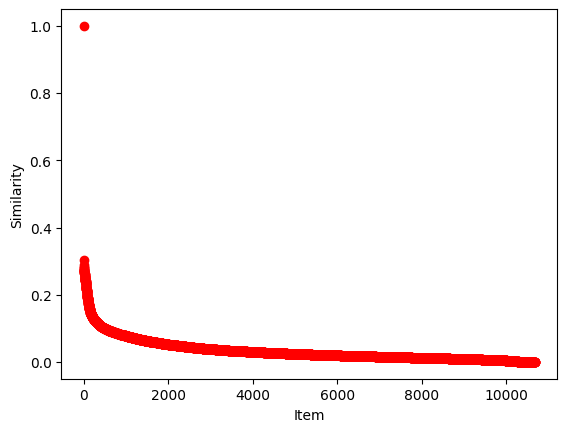

In [9]:
sorted_item_indices = np.argsort(-similarity_vector)

pyplot.plot(similarity_vector[sorted_item_indices], 'ro')
pyplot.ylabel('Similarity')
pyplot.xlabel('Item')
pyplot.show()

### Let's compute the whole similarity and see the predictions for a certain item

In [10]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

similarity_object = Compute_Similarity_Python(URM_train, shrink=100, 
                                              topK=50, normalize=True, 
                                              similarity = "cosine")

W_sparse = similarity_object.compute_similarity()

Similarity column 10681 (100.0%), 190.03 column/sec. Elapsed time 56.21 sec


In [11]:
user_id = 80

user_profile = URM_train[user_id]
scores = user_profile.dot(W_sparse).toarray().ravel()

ranking = scores.argsort()[::-1]

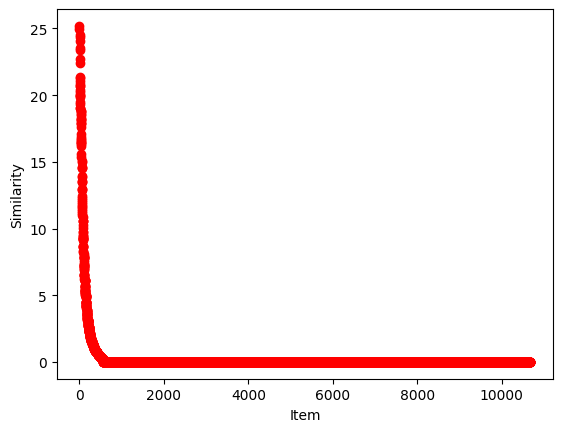

In [12]:
pyplot.plot(scores[ranking], 'ro')
pyplot.ylabel('Similarity')
pyplot.xlabel('Item')
pyplot.show()

### Then compute the final recommendation list

In [13]:
ranking[0:10]

array([ 93,  74, 175,  85,  75,  83,  26,  11,  82,  84])

## Put all together in a class

In [14]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python
import numpy as np

class ItemKNNCFRecommender(object):
    
    def __init__(self, URM):
        self.URM = URM
        
            
    def fit(self, topK=50, shrink=100, normalize=True, similarity="cosine"):
        
        similarity_object = Compute_Similarity_Python(self.URM, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.W_sparse = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

## Test our CF recommender:

In [15]:
recommender = ItemKNNCFRecommender(URM_train)
recommender.fit(shrink=0.0, topK=50)

Similarity column 10681 (100.0%), 192.26 column/sec. Elapsed time 55.55 sec


#### Let's compute recommendations for a fixed group of users

In [16]:
import time

n_users_to_test = 1000

start_time = time.time()

for user_id in range(n_users_to_test):
    recommender.recommend(user_id, at=5)
    
end_time = time.time()

print("Reasonable implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))


Reasonable implementation speed is 680.52 usr/sec


## Remember to keep the URM in CSR format!

## Hyperarameter tuning

#### Once we have built our model we can play with its parameters
* Number of neighbors
* Shrinkage
* Similarity type

#### Optimize the recommendation qualtiy on the validation data, then use those hyperparameters to train the model in all the data you have (train + validation) and evaluate on the test data

#### Number of neighbors

In [17]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender

x_tick = [10, 50, 100, 200, 500]
MAP_per_k = []

for topK in x_tick:
    
    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(shrink=0.0, topK=topK)
    
    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    
    MAP_per_k.append(result_df.loc[10]["MAP"])

ItemKNNCFRecommender: URM Detected 56 ( 0.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 10681 (100.0%), 194.92 column/sec. Elapsed time 54.80 sec
EvaluatorHoldout: Processed 69613 (100.0%) in 30.41 sec. Users per second: 2289
ItemKNNCFRecommender: URM Detected 56 ( 0.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 10681 (100.0%), 194.24 column/sec. Elapsed time 54.99 sec
EvaluatorHoldout: Processed 69613 (100.0%) in 34.00 sec. Users per second: 2048
ItemKNNCFRecommender: URM Detected 56 ( 0.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 10681 (100.0%), 192.55 column/sec. Elapsed time 55.47 sec
EvaluatorHoldout: Processed 69613 (100.0%) in 36.35 sec. Users per second: 1915
ItemKNNCFRecommender: URM Detected 56 ( 0.5%) items with no interactions.
Unable to load Cython Compute_Similarity, revertin

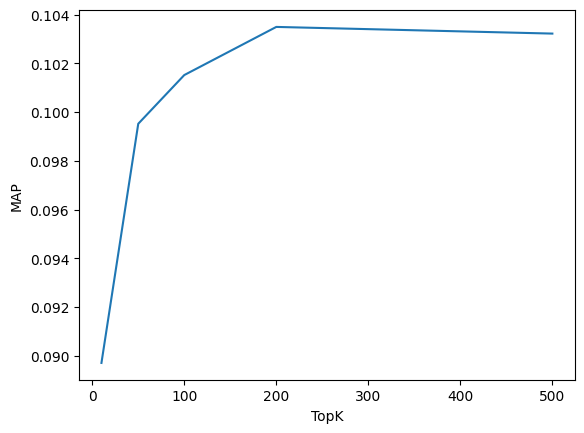

In [18]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

#### On this dataset the number of neighbors has a great impact on MAP.

#### Different datasets will behave in different ways.

### Shrinkage

In [19]:
x_tick = [0, 10, 50, 100, 200, 500]
MAP_per_shrinkage = []

for shrink in x_tick:
    
    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(shrink=shrink, topK=100)
    
    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    
    MAP_per_shrinkage.append(result_df.loc[10]["MAP"])

ItemKNNCFRecommender: URM Detected 56 ( 0.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 10681 (100.0%), 194.01 column/sec. Elapsed time 55.05 sec
EvaluatorHoldout: Processed 69613 (100.0%) in 36.29 sec. Users per second: 1918
ItemKNNCFRecommender: URM Detected 56 ( 0.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 10681 (100.0%), 193.62 column/sec. Elapsed time 55.16 sec
EvaluatorHoldout: Processed 69613 (100.0%) in 36.47 sec. Users per second: 1909
ItemKNNCFRecommender: URM Detected 56 ( 0.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 10681 (100.0%), 192.97 column/sec. Elapsed time 55.35 sec
EvaluatorHoldout: Processed 69613 (100.0%) in 36.73 sec. Users per second: 1895
ItemKNNCFRecommender: URM Detected 56 ( 0.5%) items with no interactions.
Unable to load Cython Compute_Similarity, revertin

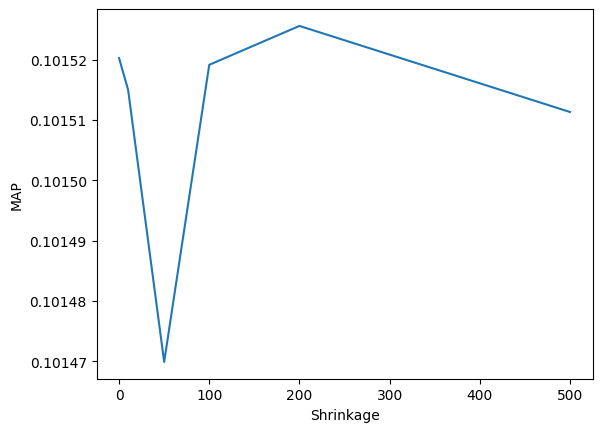

In [20]:
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

#### The shrinkage value (i.e. support) has no impact. Combine a parameter search with the two to ensure maximum recommendation quality

## REMINDER: Be careful, overfitting!

#### While a thorough parameter tuning might result in significantly higher MAP on your validation split, it could have only marginally better or even worse MAP on the test set

# User-based Collaborative Filtering

#### We apply the cosine similarity again, but using the URM rows

In [21]:
user_id = 80
shrink = 10

numerator_vector = URM_train[user_id].dot(URM_train.T).toarray().ravel()

user_norms = np.sqrt(np.array(URM_train.T.power(2).sum(axis=0))).ravel()
denominator_vector = user_norms[user_id] * user_norms + shrink + 1e-6

similarity_vector = numerator_vector/denominator_vector

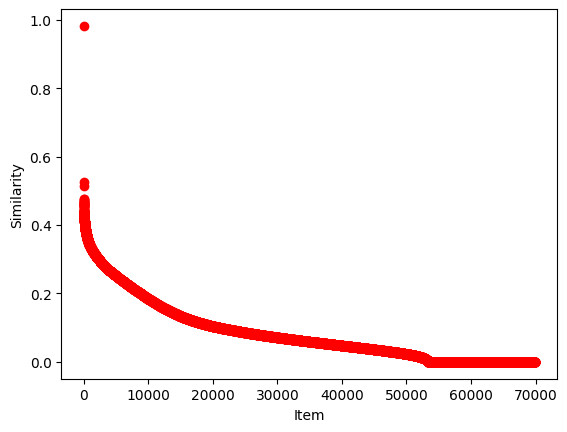

In [22]:
sorted_user_indices = np.argsort(-similarity_vector)

pyplot.plot(similarity_vector[sorted_user_indices], 'ro')
pyplot.ylabel('Similarity')
pyplot.xlabel('Item')
pyplot.show()

### Let's compute the whole similarity and see the predictions for a certain user

In [23]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

similarity_object = Compute_Similarity_Python(URM_train.T, shrink=100, 
                                              topK=50, normalize=True, 
                                              similarity = "cosine")

W_sparse = similarity_object.compute_similarity()

Similarity column 69878 (100.0%), 320.58 column/sec. Elapsed time 3.63 min


#### Note that in this case the prediction is computed in a different way compared to the Item based

In [24]:
user_id = 80

scores = W_sparse[user_id,:].dot(URM_train).toarray().ravel()

ranking = scores.argsort()[::-1]

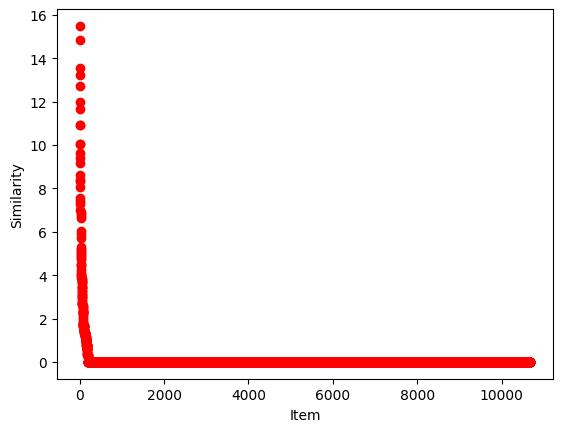

In [25]:
pyplot.plot(scores[ranking], 'ro')
pyplot.ylabel('Similarity')
pyplot.xlabel('Item')
pyplot.show()

### Then compute the final recommendation list

In [26]:
ranking[0:10]

array([  77,  213,   88, 1293,    1,   74, 1406,   22, 1006,    3])

## Put all together in a class

In [27]:
class UserKNNCFRecommender(object):
    
    def __init__(self, URM):
        self.URM = URM
        
            
    def fit(self, topK=50, shrink=100, normalize=True, similarity="cosine"):
        
        similarity_object = Compute_Similarity_Python(self.URM.T, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.W_sparse = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        
        scores = self.W_sparse[user_id, :].dot(self.URM).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

## Test our CF recommender:

In [28]:
recommender = UserKNNCFRecommender(URM_train)
recommender.fit(shrink=0.0, topK=50)

Similarity column 69878 (100.0%), 323.82 column/sec. Elapsed time 3.60 min


####  Let's compute recommendations for a fixed group of users

In [29]:
import time

n_users_to_test = 1000

start_time = time.time()

for user_id in range(n_users_to_test):
    recommender.recommend(user_id, at=5)
    
end_time = time.time()

print("Reasonable implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))


Reasonable implementation speed is 1792.08 usr/sec


## Hyperparameter tuning

#### Once we have built our model we can play with its parameters
* Number of neighbors
* Shrinkage
* Similarity type

#### Number of neighbors

In [30]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender

x_tick = [10, 50, 100, 200, 500]
MAP_per_k = []

for topK in x_tick:
    
    recommender = UserKNNCFRecommender(URM_train)
    recommender.fit(shrink=0.0, topK=topK)
    
    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    
    MAP_per_k.append(result_df.loc[10]["MAP"])

UserKNNCFRecommender: URM Detected 56 ( 0.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 69878 (100.0%), 326.11 column/sec. Elapsed time 3.57 min
EvaluatorHoldout: Processed 69613 (100.0%) in 29.07 sec. Users per second: 2395
UserKNNCFRecommender: URM Detected 56 ( 0.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 69878 (100.0%), 320.22 column/sec. Elapsed time 3.64 min
EvaluatorHoldout: Processed 69613 (100.0%) in 32.26 sec. Users per second: 2158
UserKNNCFRecommender: URM Detected 56 ( 0.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 69878 (100.0%), 320.83 column/sec. Elapsed time 3.63 min
EvaluatorHoldout: Processed 69613 (100.0%) in 34.72 sec. Users per second: 2005
UserKNNCFRecommender: URM Detected 56 ( 0.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting t

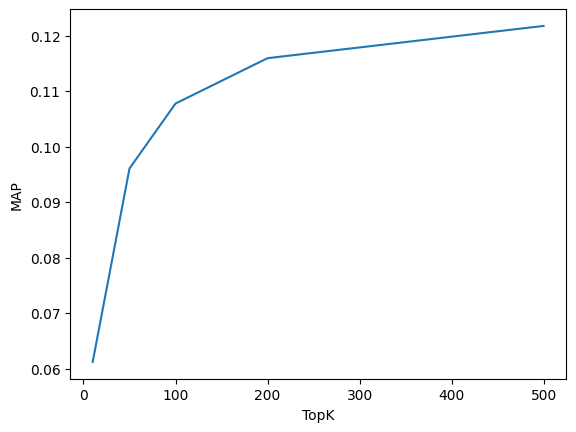

In [31]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

#### On this dataset the number of neighbors does not have a great impact on MAP. Higher values of TopK might work even better

#### Different datasets will behave in different ways.

### Shrinkage

In [32]:
x_tick = [0, 10, 50, 100, 200, 500]
MAP_per_shrinkage = []

for shrink in x_tick:
    
    recommender = UserKNNCFRecommender(URM_train)
    recommender.fit(shrink=shrink, topK=100)
    
    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    
    MAP_per_shrinkage.append(result_df.loc[10]["MAP"])

UserKNNCFRecommender: URM Detected 56 ( 0.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 69878 (100.0%), 324.27 column/sec. Elapsed time 3.59 min
EvaluatorHoldout: Processed 69613 (100.0%) in 34.42 sec. Users per second: 2023
UserKNNCFRecommender: URM Detected 56 ( 0.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 69878 (100.0%), 319.99 column/sec. Elapsed time 3.64 min
EvaluatorHoldout: Processed 69613 (100.0%) in 34.48 sec. Users per second: 2019
UserKNNCFRecommender: URM Detected 56 ( 0.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 69878 (100.0%), 322.37 column/sec. Elapsed time 3.61 min
EvaluatorHoldout: Processed 69613 (100.0%) in 34.26 sec. Users per second: 2032
UserKNNCFRecommender: URM Detected 56 ( 0.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting t

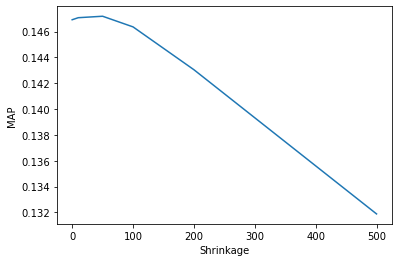

In [18]:
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

### Comparing different similarity heuristics

#### Let's see how different are the similarities 

In [19]:
similarity_heuristic_list = ["cosine", "dice", "jaccard", "pearson"]
similarity_dict = {}

for similarity_heuristic in similarity_heuristic_list:
    
    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(shrink=0.0, topK=100, similarity = similarity_heuristic)
    
    similarity_dict[similarity_heuristic] = recommender.W_sparse

ItemKNNCFRecommender: URM Detected 63 ( 0.6%) items with no interactions.
Similarity column 10681 (100.0%), 994.69 column/sec. Elapsed time 10.74 sec
ItemKNNCFRecommender: URM Detected 63 ( 0.6%) items with no interactions.
Similarity column 10681 (100.0%), 1031.11 column/sec. Elapsed time 10.36 sec
ItemKNNCFRecommender: URM Detected 63 ( 0.6%) items with no interactions.
Similarity column 10681 (100.0%), 997.98 column/sec. Elapsed time 10.70 sec
ItemKNNCFRecommender: URM Detected 63 ( 0.6%) items with no interactions.
Similarity column 10681 (100.0%), 1025.82 column/sec. Elapsed time 10.41 sec


#### Let's see what is the similarity distribution

In [20]:
W_cosine = similarity_dict["cosine"]
W_cosine.tocoo()

coordinates_sorted = np.argsort(-W_cosine.data)

cosine_similarities_sorted = W_cosine.data[coordinates_sorted]
cosine_similarities_sorted

array([9.9999994e-01, 9.9999994e-01, 9.9999994e-01, ..., 1.0756674e-03,
       1.0055839e-03, 9.6262665e-04], dtype=float32)

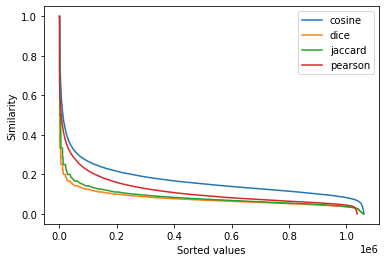

In [21]:
for similarity_heuristic in similarity_heuristic_list:
    W_sparse = similarity_dict[similarity_heuristic]
    
    pyplot.plot(-np.sort(-W_sparse.data), label=similarity_heuristic)
    
    
pyplot.ylabel('Similarity')
pyplot.xlabel('Sorted values')
pyplot.legend()
pyplot.show()

In [22]:
W_cosine = similarity_dict["cosine"]
W_cosine.nonzero()

(array([    0,     0,     0, ..., 10675, 10675, 10675], dtype=int32),
 array([   12,   128,   310, ...,  9907, 10233, 10445], dtype=int32))

In [23]:
cosine_sorted_coordinates = np.argsort(-np.array(W_cosine[W_cosine.nonzero()]).ravel())
cosine_sorted_coordinates

array([ 956037, 1024222, 1024223, ...,   47813,   19458,   34045],
      dtype=int64)

In [24]:
W_sparse = similarity_dict["cosine"]
similarity_values = np.array(W_sparse[W_cosine.nonzero()]).ravel()
similarity_values[cosine_sorted_coordinates]

array([9.9999994e-01, 9.9999994e-01, 9.9999994e-01, ..., 1.0756674e-03,
       1.0055839e-03, 9.6262665e-04], dtype=float32)

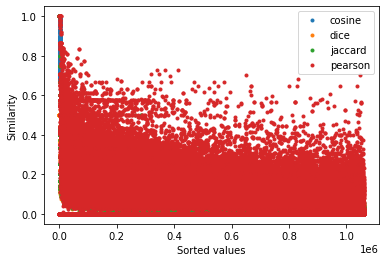

In [25]:
for similarity_heuristic in similarity_heuristic_list:
    W_sparse = similarity_dict[similarity_heuristic]
    
    # Sort similarities according to cosine
    similarity_values = np.array(W_sparse[W_cosine.nonzero()]).ravel()
    
    pyplot.plot(similarity_values[cosine_sorted_coordinates], 
                label=similarity_heuristic,
                marker=".",
                linestyle ="")
    
    
pyplot.ylabel('Similarity')
pyplot.xlabel('Sorted values')
pyplot.legend()
pyplot.show()

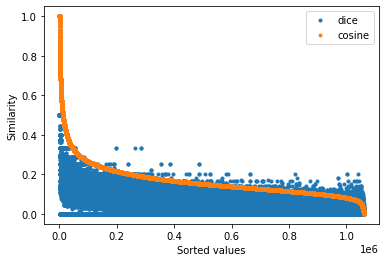

In [26]:
for similarity_heuristic in ["dice", "cosine"]:
    W_sparse = similarity_dict[similarity_heuristic]
    
    # Sort similarities according to cosine
    similarity_values = np.array(W_sparse[W_cosine.nonzero()]).ravel()
    
    pyplot.plot(similarity_values[cosine_sorted_coordinates],
                label=similarity_heuristic,
                marker=".",
                linestyle ="")
    
    
pyplot.ylabel('Similarity')
pyplot.xlabel('Sorted values')
pyplot.legend()
pyplot.show()

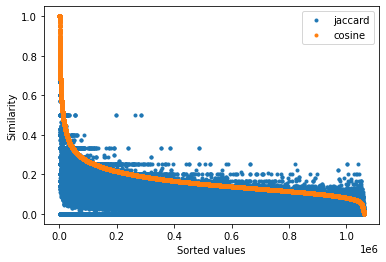

In [27]:
for similarity_heuristic in ["jaccard", "cosine"]:
    W_sparse = similarity_dict[similarity_heuristic]
    
    # Sort similarities according to cosine
    similarity_values = np.array(W_sparse[W_cosine.nonzero()]).ravel()
    
    pyplot.plot(similarity_values[cosine_sorted_coordinates], 
                label=similarity_heuristic,
                marker=".",
                linestyle ="")
    
    
pyplot.ylabel('Similarity')
pyplot.xlabel('Sorted values')
pyplot.legend()
pyplot.show()

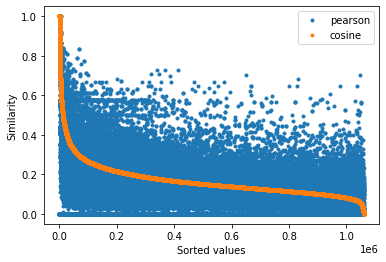

In [28]:
for similarity_heuristic in ["pearson", "cosine"]:
    W_sparse = similarity_dict[similarity_heuristic]
    
    # Sort similarities according to cosine
    similarity_values = np.array(W_sparse[W_cosine.nonzero()]).ravel()
    
    pyplot.plot(similarity_values[cosine_sorted_coordinates], 
                label=similarity_heuristic,
                marker=".",
                linestyle ="")
    
    
pyplot.ylabel('Similarity')
pyplot.xlabel('Sorted values')
pyplot.legend()
pyplot.show()

## Comparing CF and CBF item-based KNNs

In [29]:
ICM_all = dataset.get_loaded_ICM_dict()["ICM_all"]
ICM_all

<10681x10126 sparse matrix of type '<class 'numpy.float64'>'
	with 128384 stored elements in Compressed Sparse Row format>

### Rewrite the content-based recommender

In [30]:
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender

content_recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
content_MAP = []

collaborative_recommender = ItemKNNCFRecommender(URM_train)
collaborative_MAP = []

x_tick = []

for topK in [50, 100, 200]:
    for shrink in [10, 50, 100]:
        
        x_tick.append("topk {}, shrink {}".format(topK, shrink))
        
        content_recommender.fit(shrink=shrink, topK=topK)
        collaborative_recommender.fit(shrink=shrink, topK=topK)
        
        result_df, _ = evaluator_test.evaluateRecommender(content_recommender)
        content_MAP.append(result_df.loc[10]["MAP"])
        
        result_df, _ = evaluator_test.evaluateRecommender(collaborative_recommender)
        collaborative_MAP.append(result_df.loc[10]["MAP"])

ItemKNNCBFRecommender: URM Detected 63 ( 0.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 63 ( 0.6%) items with no interactions.
Similarity column 10681 (100.0%), 5030.40 column/sec. Elapsed time 2.12 sec
Similarity column 10681 (100.0%), 1030.12 column/sec. Elapsed time 10.37 sec
EvaluatorHoldout: Processed 69796 (100.0%) in 49.24 sec. Users per second: 1417
EvaluatorHoldout: Processed 69796 (100.0%) in 57.65 sec. Users per second: 1211
Similarity column 10681 (100.0%), 5189.54 column/sec. Elapsed time 2.06 sec
Similarity column 10681 (100.0%), 883.65 column/sec. Elapsed time 12.09 sec
EvaluatorHoldout: Processed 69796 (100.0%) in 57.16 sec. Users per second: 1221
EvaluatorHoldout: Processed 69796 (100.0%) in 56.29 sec. Users per second: 1240
Similarity column 10681 (100.0%), 5248.61 column/sec. Elapsed time 2.04 sec
Similarity column 10681 (100.0%), 874.55 column/sec. Elapsed time 12.21 sec
EvaluatorHoldout: Processed 69796 (100.0%) in 57.19 sec. Users per second:

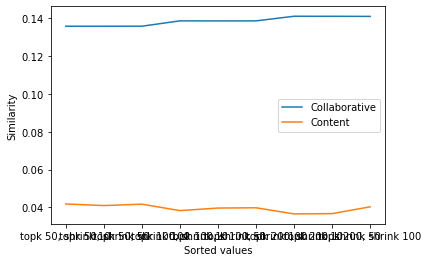

In [31]:
pyplot.plot(x_tick, collaborative_MAP, label="Collaborative")
pyplot.plot(x_tick, content_MAP, label="Content")   

pyplot.ylabel('Similarity')
pyplot.xlabel('Sorted values')
pyplot.legend()
pyplot.show()

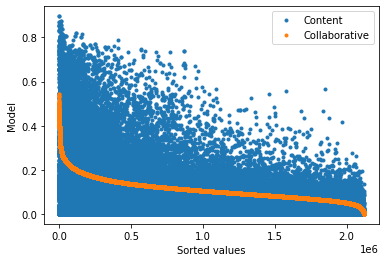

In [32]:
W_collaborative = collaborative_recommender.W_sparse
W_content = content_recommender.W_sparse
    
# Sort similarities according to cosine
collaborative_similarity_values = np.array(W_collaborative[W_collaborative.nonzero()]).ravel()
content_similarity_values = np.array(W_content[W_collaborative.nonzero()]).ravel()

sorted_args = np.argsort(-collaborative_similarity_values)

pyplot.plot(content_similarity_values[sorted_args], 
            label="Content",
            marker=".",
            linestyle ="")

pyplot.plot(collaborative_similarity_values[sorted_args], 
            label="Collaborative",
            marker=".",
            linestyle ="")
    
pyplot.ylabel('Model')
pyplot.xlabel('Sorted values')
pyplot.legend()
pyplot.show()

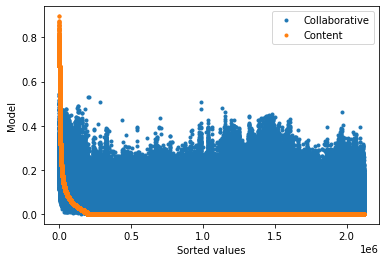

In [33]:
sorted_args = np.argsort(-content_similarity_values)

pyplot.plot(collaborative_similarity_values[sorted_args], 
            label="Collaborative",
            marker=".",
            linestyle ="")

pyplot.plot(content_similarity_values[sorted_args], 
            label="Content",
            marker=".",
            linestyle ="")
    
pyplot.ylabel('Model')
pyplot.xlabel('Sorted values')
pyplot.legend()
pyplot.show()

## Collaborative is outperforming content-based by a large margin, as we could expect

### Let's try to see how the recommendations are distributed

In [34]:
x_tick = np.arange(URM_all.shape[1])
counter_content = np.zeros(URM_all.shape[1])
counter_collaborative = np.zeros(URM_all.shape[1])

for user_id in range(URM_all.shape[0]):
    recs = collaborative_recommender.recommend(user_id)[:10]
    counter_collaborative[recs] += 1
    
    recs = content_recommender.recommend(user_id)[:10]
    counter_content[recs] += 1
    
    if user_id % 10000 == 0:
        print("Recommended to user {}/{}".format(user_id, URM_all.shape[0]))

Recommended to user 0/69878
Recommended to user 10000/69878
Recommended to user 20000/69878
Recommended to user 30000/69878
Recommended to user 40000/69878
Recommended to user 50000/69878
Recommended to user 60000/69878


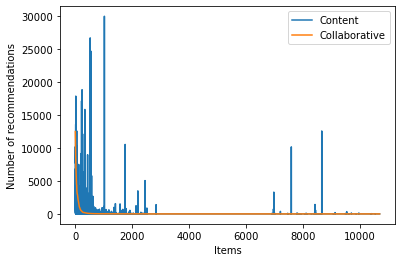

In [35]:
sorted_items = np.argsort(-counter_collaborative)
       
pyplot.plot(x_tick, counter_content[sorted_items], label = "Content")
pyplot.plot(x_tick, counter_collaborative[sorted_items], label = "Collaborative")

pyplot.ylabel('Number of recommendations')
pyplot.xlabel('Items')
pyplot.legend()
pyplot.show()

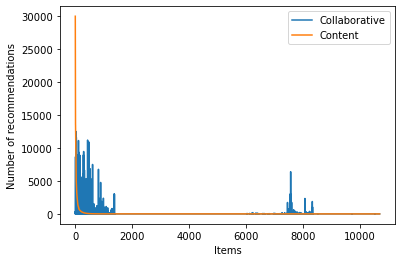

In [36]:
sorted_items = np.argsort(-counter_content)

pyplot.plot(x_tick, counter_collaborative[sorted_items], label = "Collaborative")
pyplot.plot(x_tick, counter_content[sorted_items], label = "Content")

pyplot.ylabel('Number of recommendations')
pyplot.xlabel('Items')
pyplot.legend()
pyplot.show()

### Ideas on what you could do to improve your model recommendation quality. We will mostly not discuss them explicitly, but if you have questions on them please send us an email or use the challenge forum. For algorithms like matrix decompositions you can use the implementation provided in the libraries (scikit-learn mostly), for other types of algorithms please check with us directly before using them.

* Feature weighting applies not only to item features or user features. The items a user interacted with can themselves be considered as user features and vice versa. Feature weighting can be applied to items and users even in a collaborative model.


* Feature selection, a specific type of feature weigthing (weights are only 0 or 1) is too useful. You may remove some items or users because they add noise. Remember, the items you remove will likely never be recommended and the users you remove will become cold users, you may need to add an ad-hoc strategy to recommend to them (for example, top popular).


* There are a lot of techniques to perform feature weigthing and selection, we saw rapidly IDF and BM25, but many other are possible, for example removing features that have low variance or features that have a low correlation with the desired model output (used in classification, more difficult in RecSys). See as initial reference: https://scikit-learn.org/stable/modules/feature_selection.html.


* Sometimes the features can be represented in a different space, for example by using Principal component analysis, Independent Component Analysis, Non-Negative Matrix Factorization or Canonical Correlation Analysis... Those will all allow you to represent the ICM (or URM in fact) as a different matrix which contains approximately the same information but represented in a different way. Usually, you have the same number of items but each item has a vector of length much lower than the number of original features, these vectors are called embeddings and their length is the number of "components" or "latent dimensions". The less you have, the more compressed the data is. Not all decompositions are interchangeable. Remember that KNNs work by looking for "common features", if you compress the data a little you may improve your model because you remove noise, but if you compress too much you end up with a set of almost completely independend features and your KNN model may not work. See: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition


* The user-item interaction value is not set in stone, you can weight that number according to some heuristics, for example you can weight less interactions of very popular items or users with huge profiles, this will impact how the item-item or user-user similarities are computed.  For example: interaction value * log(popularity) or sqrt(popularity) or other ways, it is a heuristic so its success depends on the data and you may need to try a few


* Implement new similarities, there is a number of variants of the heuristics we have shown you or you can design your own combining them and adding new hyperparameters to weight them. See for example: "Vito Walter Anelli, Tommaso Di Noia, Eugenio Di Sciascio, Azzurra Ragone, and Joseph Trotta. 2019. The importance of being dissimilar in recommendation. In Proceedings of the 34th ACM/SIGAPP Symposium on Applied Computing (SAC '19)": https://dl.acm.org/doi/pdf/10.1145/3297280.3297360 


* Optimization of hyperparameters is very important in any prediction/classification/recommendation task. Sometimes spending a few extra hours optimizing is more efficient than spending a few days in searching for new ideas or models. Combine the two for the best outcome!


* Keep it simple. The literature is full of complex or over-complex models that promise in theory of being able to learn everything but, in practice, they may be very difficult to implement, train and optimize. Prefer simple models to very complex ones, you may spend a lot of time to get them to run and train only to discover that it takes 15 hours for them to complete their training on a single hyperparameter set.  "Maurizio Ferrari Dacrema, Paolo Cremonesi, and Dietmar Jannach. 2019. Are we really making much progress? A worrying analysis of recent neural recommendation approaches. In Proceedings of the 13th ACM Conference on Recommender Systems (RecSys '19).": https://doi.org/10.1145/3298689.3347058 https://arxiv.org/abs/1907.06902